<div style="margin-bottom: 15px; padding: 15px; color: #31708e; background-color: #d9edff; border: 1px solid #bce8f1; border-radius: 5px;">
    
<font size=+2>My Information:</font></b>

  Name</b>: [Venkata Sai Kumar Gottumukkala]
  </br>

  Student ID Number</b>:  [862393318]
  </br>
    
Some parts of this notebook are inspired from the Deep Learning Specilization course from [Deeplearning.ai](https://www.deeplearning.ai/courses/deep-learning-specialization/) offered on coursera that I am currently doing along with my CS228 Intro to Deep Learning course at UCR.
</div>

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform

import numpy as np
import random
import matplotlib.pyplot as plt

### Load CIFAR-10 dataset

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [5]:
# Get the indices of the examples for each class
class_indices = np.squeeze(y_train)
selected_indices = []

# Iterate over the classes and randomly select 1,000 examples
for class_label in range(10):  # There are 10 classes in CIFAR-10
    indices = np.where(class_indices == class_label)[0]
    selected_indices.extend(np.random.choice(indices, size=1000, replace=False))

# Select the examples based on the sampled indices
x_train_data = x_train[selected_indices]
y_train_data = y_train[selected_indices]

# Shuffle the data
combined_data = list(zip(x_train_data, y_train_data))
np.random.shuffle(combined_data)
x_train_data, y_train_data = zip(*combined_data)

# Convert the shuffled data back to numpy arrays
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

print(x_train_data.shape)
print(y_train_data.shape)

(10000, 32, 32, 3)
(10000, 1)


In [6]:
# Convert labels to categorical format
y_train_data = keras.utils.to_categorical(y_train_data, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(x_train_data.shape)
print(y_train_data.shape)

(10000, 32, 32, 3)
(10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


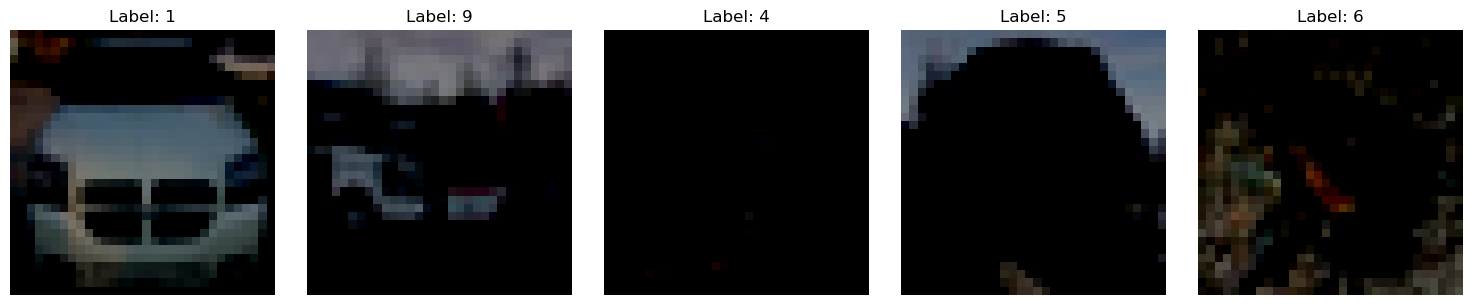

In [7]:
# Select 5 random indices
random_indices = random.sample(range(10000), 5)

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_data[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_data[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Building blocks for ResNet model

In [8]:
# Convolutional Block
def conv_block(x, filters, strides=1):
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size = 3, strides=strides, padding='same', kernel_initializer = glorot_uniform())(x)
    x = BatchNormalization(axis = 3)(x, training=True)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = glorot_uniform())(x)
    x = BatchNormalization(axis = 3)(x, training=True)
    
    # Skip connection
    if strides > 1:
        shortcut = Conv2D(filters, 1, strides=strides, padding='same', kernel_initializer = glorot_uniform())(shortcut)
        shortcut = BatchNormalization(axis = 3)(shortcut, training=True)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [9]:
# Identity Block
def identity_block(x, filters):
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = random_uniform())(x)
    x = BatchNormalization(axis = 3)(x, training=True)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size = 3, padding='same', kernel_initializer = random_uniform())(x)
    x = BatchNormalization(axis = 3)(x, training=True)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

### ResNet-20 model:

In [10]:
# ResNet-20 Model
def ResNet20():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    
    # Initial Convolutional Layer
    x = Conv2D(16, 3, padding='same', kernel_initializer = glorot_uniform())(inputs)
    x = BatchNormalization(axis = 3)(x, training=True)
    x = Activation('relu')(x)
    
    # Stage 1: 1 Convolutional Block, 2 Identity Blocks
    x = conv_block(x, 16)
    x = identity_block(x, 16)
    x = identity_block(x, 16)
    
    # Stage 2: 1 Convolutional Block, 2 Identity Blocks
    x = conv_block(x, 32, strides=2)
    x = identity_block(x, 32)
    x = identity_block(x, 32)
    
    # Stage 3: 1 Convolutional Block, 2 Identity Blocks
    x = conv_block(x, 64, strides=2)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    
    # Final Fully Connected Layer
    x = AveragePooling2D(8)(x)
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# Create an instance of the ResNet-20 model
resnet20 = ResNet20()

Metal device set to: Apple M2 Pro


In [12]:
# Print the model summary
resnet20.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

 activation_8 (Activation)      (None, 16, 16, 32)   0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 32)  128         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
          

                                                                                                  
 batch_normalization_20 (BatchN  (None, 8, 8, 64)    256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 8, 8, 64)     0           ['batch_normalization_20[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)   

In [13]:
def plots(train_acc_history, test_acc_history, train_loss_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    epochs = range(1, len(train_acc_history) + 1) 
    ax1.plot(epochs, train_acc_history, color='blue', label='Train Accuracy')
    ax1.plot(epochs, test_acc_history, color='green', label='Test Accuracy')
    ax1.set_title('Training and Testing Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(epochs, train_loss_history, color='m', label='Training Loss')
    ax2.set_title('Training loss vs Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Training Loss')
    ax2.grid(True)
    ax2.legend()

    plt.show()

### Training without Data Agumentation:

2023-05-23 20:46:40.177417: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 4s 11ms/step - loss: 2.2319 - accuracy: 0.5948
Test Accuracy: 0.59


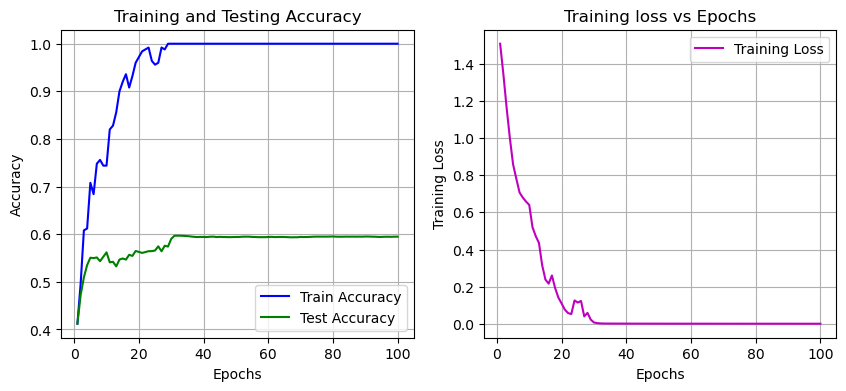

In [14]:
# Compile the model
resnet20.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# Initialize empty lists to store history
train_accuracy = []
val_accuracy = []
train_loss = []

batch_size = 250
epochs = 100
m = x_train_data.shape[0]

# Iterate over epochs
for epoch in range(epochs):
    # Iterate over mini-batches
    for i in range(0, m, batch_size):
        x_batch = x_train_data[i:i+batch_size]
        y_batch = y_train_data[i:i+batch_size]

        # Train on the current mini-batch
        history = resnet20.train_on_batch(x_batch, y_batch)

    # Append current batch metrics to the history lists
    train_accuracy.append(history[1])
    train_loss.append(history[0])

    # Evaluate on the validation data after each epoch
    val_metrics = resnet20.evaluate(x_test, y_test, verbose=0)
    val_accuracy.append(val_metrics[1])
    
# Evaluate the model on the test set
test_loss, test_accuracy = resnet20.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
plots(train_accuracy, val_accuracy, train_loss)

### Random Shift:

In [15]:
def random_shift(image, label, K):
    assert image.shape == (32, 32, 3), "Invalid image shape"

    # Calculate random shift values
    k1 = np.random.randint(-K, K+1)
    k2 = np.random.randint(-K, K+1)

    # Pad the image with zeros
    padded_image = np.pad(image, ((4, 4), (4, 4), (0, 0)), mode='constant')

    # Perform the random shift
    shifted_image = padded_image[4+k1:4+k1+32, 4+k2:4+k2+32, :]

    # Handle cases where shifted region goes beyond padded boundaries
    if shifted_image.shape != (32, 32, 3):
        shifted_image = image  # Keep the original image
        flipped_label = label
    else:
        # Apply horizontal flip with 50% probability
        if np.random.rand() < 0.5:
            shifted_image = np.fliplr(shifted_image)
        flipped_label = label

    assert image.shape == shifted_image.shape
    assert label.shape == flipped_label.shape

    return shifted_image, flipped_label

In [16]:
shifted_images = []
flipped_labels = []
for i in range(x_train_data.shape[0]):
    img, label = random_shift(x_train_data[i], y_train_data[i], K=4)
    shifted_images.append(img)
    flipped_labels.append(label)

x_train_random = np.array(shifted_images)
y_train_random = np.array(flipped_labels)

print(x_train_random.shape)
print(y_train_random.shape)

(10000, 32, 32, 3)
(10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


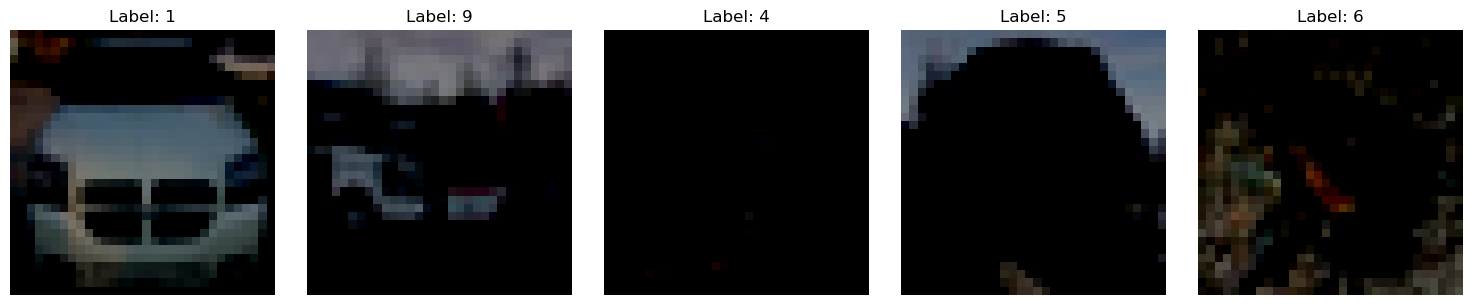

In [17]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_data[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_data[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


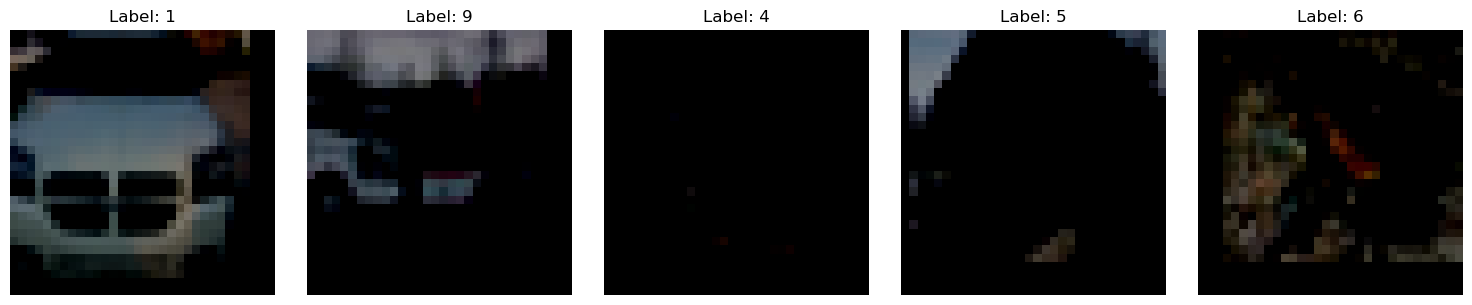

In [18]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(shifted_images[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(flipped_labels[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

313/313 [==============================] - 4s 11ms/step - loss: 2.3483 - accuracy: 0.5786
Test Accuracy: 0.58


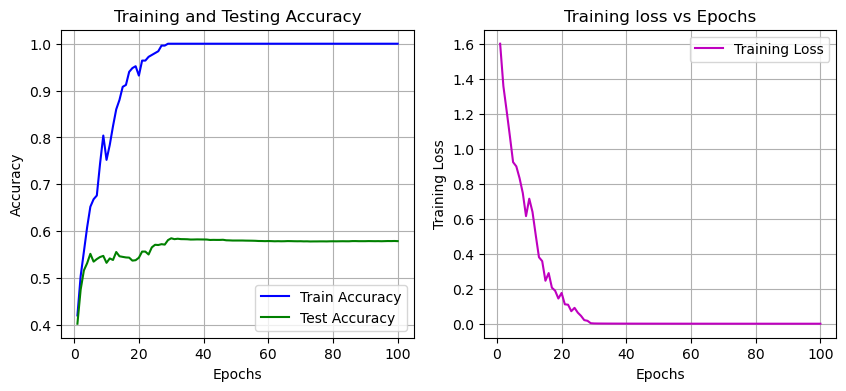

In [19]:
# Recreate the model instance
model = ResNet20()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# Initialize empty lists to store history
train_accuracy = []
val_accuracy = []
train_loss = []

batch_size = 250
epochs = 100
m = x_train_data.shape[0]

# Iterate over epochs
for epoch in range(epochs):
    # Iterate over mini-batches
    for i in range(0, m, batch_size):
        x_batch = x_train_random[i:i+batch_size]
        y_batch = y_train_random[i:i+batch_size]

        # Train on the current mini-batch
        history = model.train_on_batch(x_batch, y_batch)

    # Append current batch metrics to the history lists
    train_accuracy.append(history[1])
    train_loss.append(history[0])

    # Evaluate on the validation data after each epoch
    val_metrics = model.evaluate(x_test, y_test, verbose=0)
    val_accuracy.append(val_metrics[1])
    
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
plots(train_accuracy, val_accuracy, train_loss)

### Cutout

In [20]:
import copy

def cutout(images, labels, p=0.5, mask_size=16):
    num_images = images.shape[0]

    # Create a copy of the images array
    images_copy = copy.deepcopy(images)

    for i in range(num_images):
        # Apply Cutout with probability p
        if np.random.rand() < p:
            image = images_copy[i]
            label = labels[i]

            height, width, _ = image.shape

            # Select a random pixel as the center of the cutout mask
            center_x = np.random.randint(0, width)
            center_y = np.random.randint(0, height)

            # Calculate the top-left corner coordinates of the cutout mask
            mask_half_size = mask_size // 2
            top = max(0, center_y - mask_half_size)
            left = max(0, center_x - mask_half_size)

            # Calculate the bottom-right corner coordinates of the cutout mask
            bottom = min(height, center_y + mask_half_size)
            right = min(width, center_x + mask_half_size)

            # Apply the cutout mask
            image[top:bottom, left:right, :] = 0

            # Update the images_copy and labels arrays with the modified image
            images_copy[i] = image
            labels[i] = label

    return images_copy, labels

In [21]:
x_train_cutoff, y_train_cutoff = cutout(x_train_data, y_train_data, p=0.5, mask_size=16)

print(x_train_cutoff.shape)
print(y_train_cutoff.shape)

(10000, 32, 32, 3)
(10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


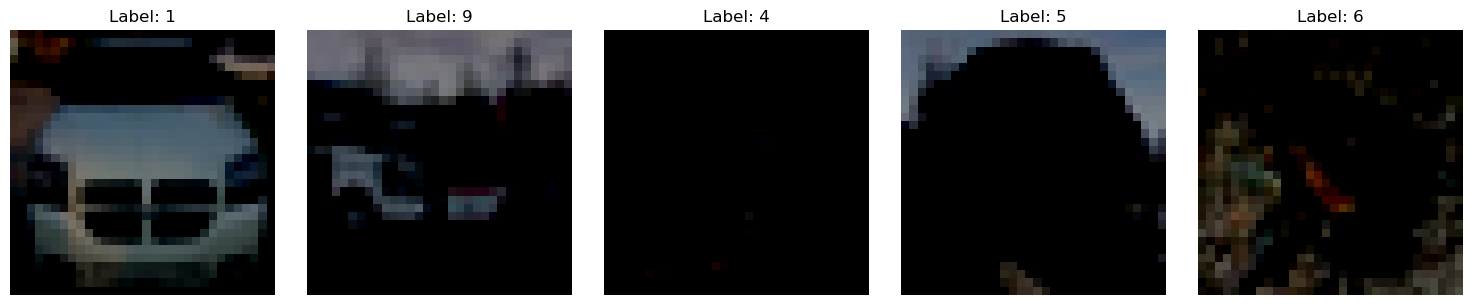

In [22]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_data[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_data[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


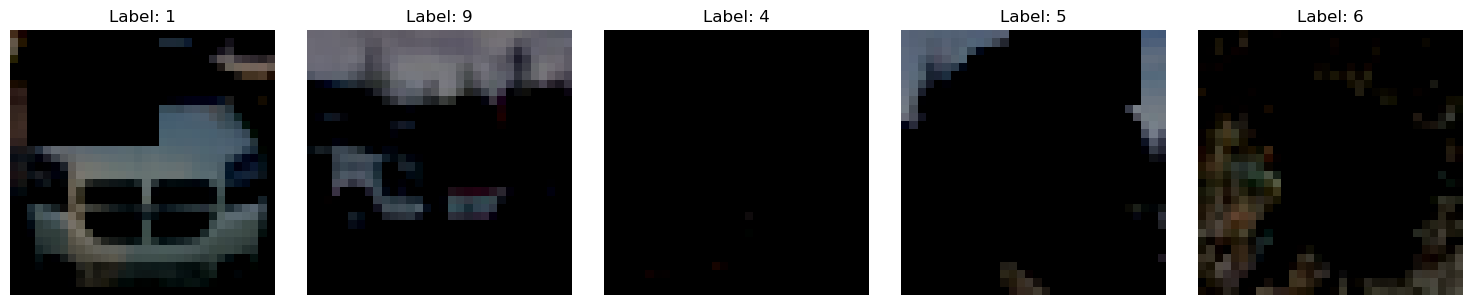

In [23]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_cutoff[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_cutoff[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

313/313 [==============================] - 4s 13ms/step - loss: 2.3524 - accuracy: 0.5768
Test Accuracy: 0.58


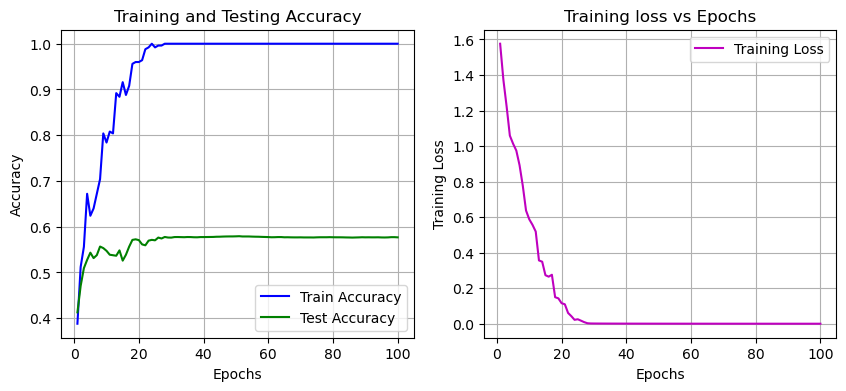

In [24]:
# Recreate the model instance
model = ResNet20()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# Initialize empty lists to store history
train_accuracy = []
val_accuracy = []
train_loss = []

batch_size = 250
epochs = 100
m = x_train_data.shape[0]

# Iterate over epochs
for epoch in range(epochs):
    # Iterate over mini-batches
    for i in range(0, m, batch_size):
        x_batch = x_train_cutoff[i:i+batch_size]
        y_batch = y_train_cutoff[i:i+batch_size]

        # Train on the current mini-batch
        history = model.train_on_batch(x_batch, y_batch)

    # Append current batch metrics to the history lists
    train_accuracy.append(history[1])
    train_loss.append(history[0])

    # Evaluate on the validation data after each epoch
    val_metrics = model.evaluate(x_test, y_test, verbose=0)
    val_accuracy.append(val_metrics[1])
    
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
plots(train_accuracy, val_accuracy, train_loss)

### MixUp

In [25]:
def mixup(x1, y1, x2, y2, alpha):
    # Sample a mixup coefficient from the beta distribution.
    beta = np.random.beta(alpha, alpha)

    # Calculate the mixed data point.
    x = beta * x1 + (1 - beta) * x2

    # Calculate the mixed label.
    y = beta * y1 + (1 - beta) * y2

    assert(x1.shape == x.shape)
    assert(y1.shape == y.shape)
    return x, y

In [26]:
def mixup_batch(x, y, alpha):
    m = x.shape[0]
    mix_data = []
    mix_label = []
    for i in range(m):
        # Generate two random integers between 0 and m
        random_int1 = np.random.randint(0, m)
        random_int2 = np.random.randint(0, m)

        x1 = x[random_int1]
        x2 = x[random_int2]
        y1 = y[random_int1]
        y2 = y[random_int2]
        mix_x, mix_y = mixup(x1, y1, x2, y2, alpha)
        mix_data.append(mix_x)
        mix_label.append(mix_y)
    
    # Convert the shuffled data back to numpy arrays
    mix_data = np.array(mix_data)
    mix_label = np.array(mix_label)

    assert(mix_data.shape == x.shape)
    assert(mix_label.shape == y.shape)

    return mix_data, mix_label

313/313 [==============================] - 4s 12ms/step - loss: 1.0792 - accuracy: 0.6583
Test Accuracy: 0.66


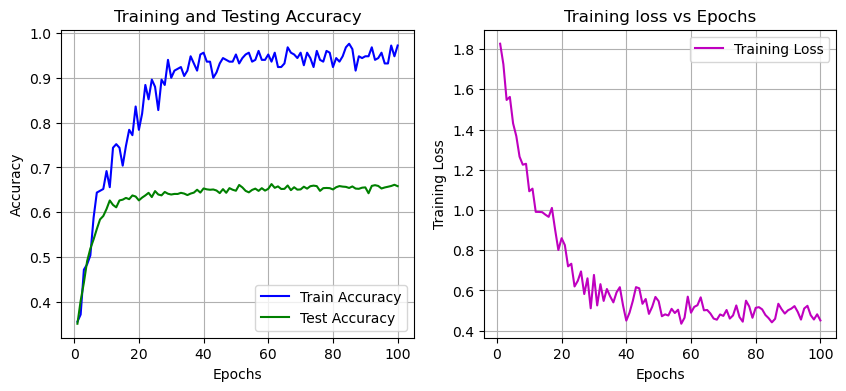

313/313 [==============================] - 4s 12ms/step - loss: 1.0904 - accuracy: 0.6463
Test Accuracy: 0.65


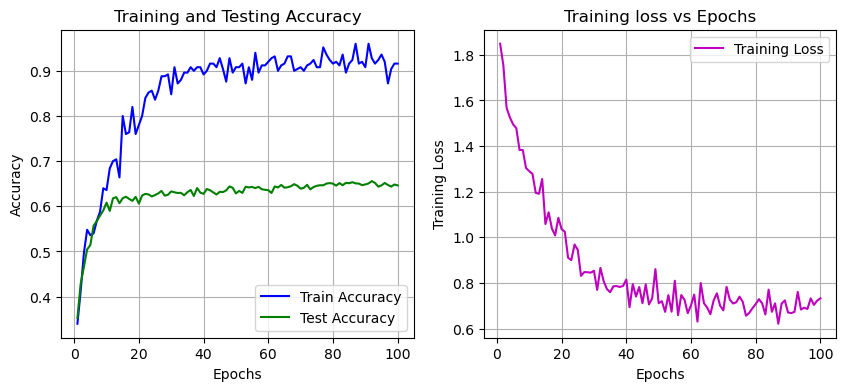

In [27]:
alpha = [0.2, 0.4]
test_acc = []
for alp in alpha:
    # Recreate the model instance
    model = ResNet20()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

    # Initialize empty lists to store history
    train_accuracy = []
    val_accuracy = []
    train_loss = []

    batch_size = 250
    epochs = 100
    m = x_train_data.shape[0]

    # Iterate over epochs
    for epoch in range(epochs):
        # Iterate over mini-batches
        for i in range(0, m, batch_size):
            x_batch = x_train_data[i:i+batch_size]
            y_batch = y_train_data[i:i+batch_size]

            mixup_data, mixup_labels = mixup_batch(x_batch, y_batch, alp)

            # Train on the current mini-batch
            history = model.train_on_batch(mixup_data, mixup_labels)

        # Append current batch metrics to the history lists
        train_accuracy.append(history[1])
        train_loss.append(history[0])

        # Evaluate on the validation data after each epoch
        val_metrics = model.evaluate(x_test, y_test, verbose=0)
        val_accuracy.append(val_metrics[1])
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    test_acc.append(test_accuracy)
    print(f"Test Accuracy: {test_accuracy:.2f}")
    plots(train_accuracy, val_accuracy, train_loss)

In [28]:
if test_acc[0] > test_acc[1]:
    alpha = 0.2
else:
    alpha = 0.4

In [29]:
print(f'alpha that gives higher accuracy: {alpha:.2f}')

alpha that gives higher accuracy: 0.20


### Combine all augmentations together

In [30]:
shifted_images = []
flipped_labels = []
for i in range(x_train_data.shape[0]):
    img, label = random_shift(x_train_data[i], y_train_data[i], K=4)
    shifted_images.append(img)
    flipped_labels.append(label)

shifted_images = np.array(shifted_images)
flipped_labels = np.array(flipped_labels)

x_train_agumented, y_train_agumented = cutout(shifted_images, flipped_labels, p=0.5, mask_size=16)

print(x_train_agumented.shape)
print(y_train_agumented.shape)

(10000, 32, 32, 3)
(10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


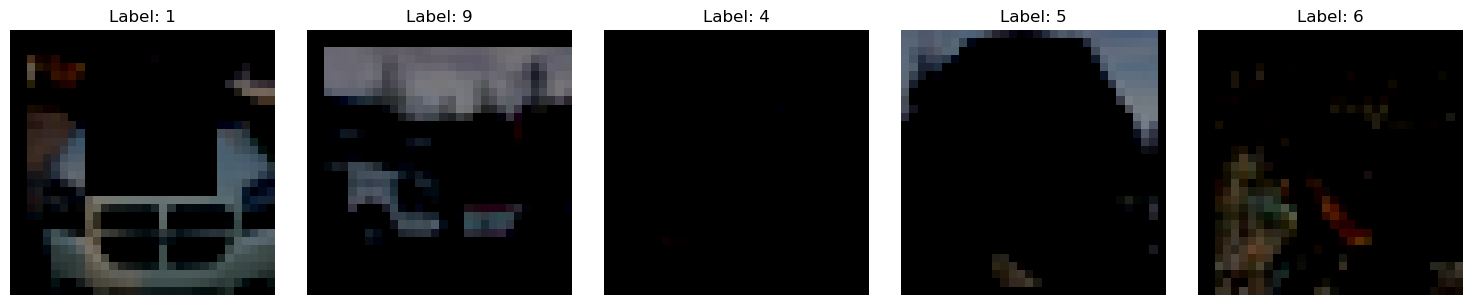

In [31]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_agumented[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_agumented[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

313/313 [==============================] - 4s 13ms/step - loss: 2.5419 - accuracy: 0.5456
Test Accuracy: 0.55


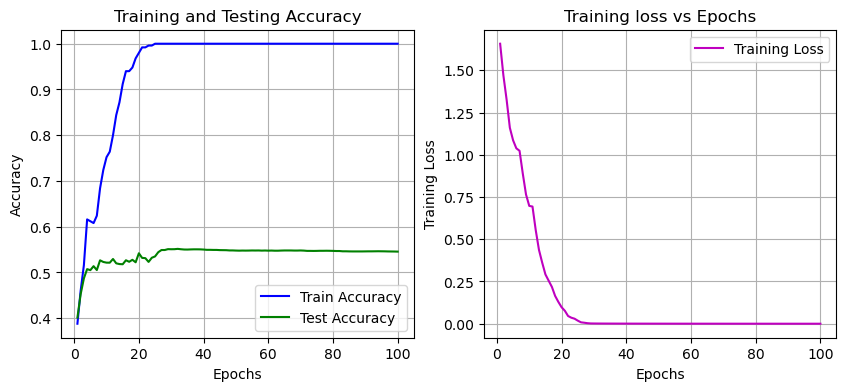

In [32]:
# Recreate the model instance
model = ResNet20()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# Initialize empty lists to store history
train_accuracy = []
val_accuracy = []
train_loss = []

batch_size = 250
epochs = 100
m = x_train_data.shape[0]

# Iterate over epochs
for epoch in range(epochs):
    # Iterate over mini-batches
    for i in range(0, m, batch_size):
        x_batch = x_train_agumented[i:i+batch_size]
        y_batch = y_train_agumented[i:i+batch_size]

        mixup_data, mixup_labels = mixup_batch(x_batch, y_batch, alpha)

        # Train on the current mini-batch
        history = model.train_on_batch(x_batch, y_batch)

    # Append current batch metrics to the history lists
    train_accuracy.append(history[1])
    train_loss.append(history[0])

    # Evaluate on the validation data after each epoch
    val_metrics = model.evaluate(x_test, y_test, verbose=0)
    val_accuracy.append(val_metrics[1])
    
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
plots(train_accuracy, val_accuracy, train_loss)

### Comment on the role of data augmentation:
1. Data augmentation helps the model to learn more invariant and robust features by exposing it to a wider range of variations in the training data. 
2. This improved feature representation often leads to better generalization and higher test accuracy when evaluating the model on unseen data. 
3. Data augmentation acts as a form of regularization by introducing randomness and variations into the training process.

#### Effect on Test Accuracy:
1. When our dataset size is large and we don't want the model to overfit the training data, this is considered as advantageous. 
2. However, because we are masking crucial information from the training dataset, which is just 10,000 images in size compared to the CIFAR10 50,000 images and other general datasets often used in industry with size of 1 million images, the test accuracy for the combined argumentation is lower here.

#### Effect on Train Accuracy:
1. The train's accuracy stays constant in comparison to before data augmentation was implemented and quickly reaches 100% accuracy.

#### Effect on convergence of optimization: 
1. The regularization effect aids in preventing overfitting, which happens when the model memorizes the training data rather than understanding broader patterns. 
2. Data augmentation can boost train and test accuracy by decreasing overfitting.
3. After data augmentation, training loss converges more quickly.
4. Although data argumentation aids in the learning of more robust and invariant features, there is a point beyond which it is of no further assistance to the model.

## Check the Images below without standardization for working of CutOff and Random_shift:

In [33]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [34]:
# Get the indices of the examples for each class
class_indices = np.squeeze(y_train)
selected_indices = []

# Iterate over the classes and randomly select 1,000 examples
for class_label in range(10):  # There are 10 classes in CIFAR-10
    indices = np.where(class_indices == class_label)[0]
    selected_indices.extend(np.random.choice(indices, size=1000, replace=False))

# Select the examples based on the sampled indices
x_train_data = x_train[selected_indices]
y_train_data = y_train[selected_indices]

# Shuffle the data
combined_data = list(zip(x_train_data, y_train_data))
np.random.shuffle(combined_data)
x_train_data, y_train_data = zip(*combined_data)

# Convert the shuffled data back to numpy arrays
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)

print(x_train_data.shape)
print(y_train_data.shape)

(10000, 32, 32, 3)
(10000, 1)


In [35]:
# Convert labels to categorical format
y_train_data = keras.utils.to_categorical(y_train_data, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(x_train_data.shape)
print(y_train_data.shape)

(10000, 32, 32, 3)
(10000, 10)


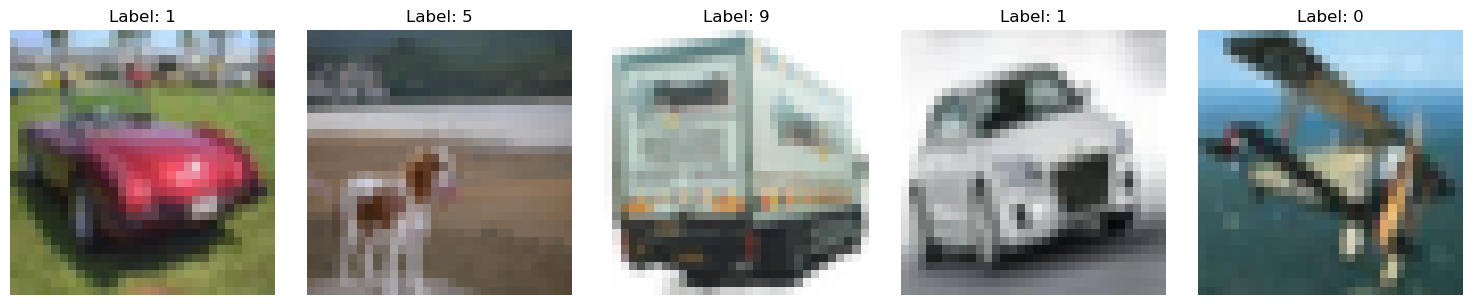

In [36]:
# Select 5 random indices
random_indices = random.sample(range(10000), 5)

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_data[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_data[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
def random_shift(image, label, K):
    assert image.shape == (32, 32, 3), "Invalid image shape"

    # Calculate random shift values
    k1 = np.random.randint(-K, K+1)
    k2 = np.random.randint(-K, K+1)

    # Pad the image with zeros
    padded_image = np.pad(image, ((4, 4), (4, 4), (0, 0)), mode='constant')

    # Perform the random shift
    shifted_image = padded_image[4+k1:4+k1+32, 4+k2:4+k2+32, :]

    # Handle cases where shifted region goes beyond padded boundaries
    if shifted_image.shape != (32, 32, 3):
        shifted_image = image  # Keep the original image
        flipped_label = label
    else:
        # Apply horizontal flip with 50% probability
        if np.random.rand() < 0.5:
            shifted_image = np.fliplr(shifted_image)
        flipped_label = label

    assert image.shape == shifted_image.shape
    assert label.shape == flipped_label.shape

    return shifted_image, flipped_label

In [38]:
shifted_images = []
flipped_labels = []
for i in range(x_train_data.shape[0]):
    img, label = random_shift(x_train_data[i], y_train_data[i], K=4)
    shifted_images.append(img)
    flipped_labels.append(label)

x_train_random = np.array(shifted_images)
y_train_random = np.array(flipped_labels)

print(x_train_random.shape)
print(y_train_random.shape)

(10000, 32, 32, 3)
(10000, 10)


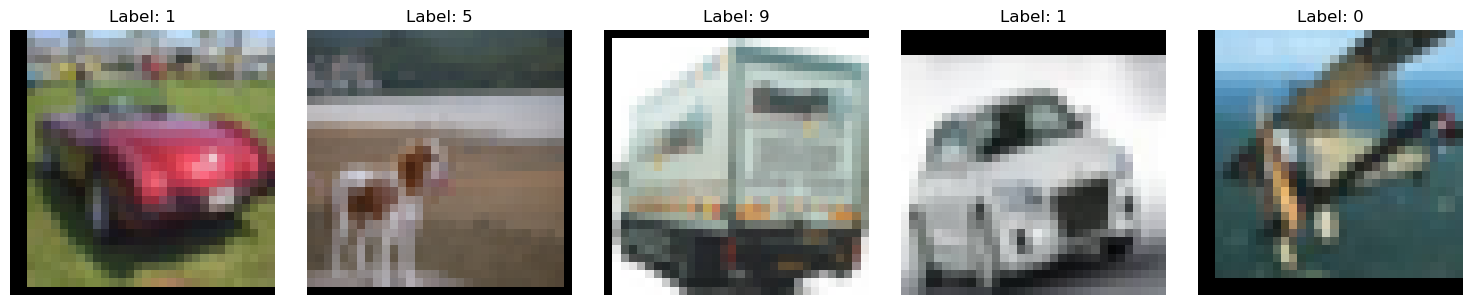

In [39]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(shifted_images[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(flipped_labels[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
import copy

def cutout(images, labels, p=0.5, mask_size=16):
    num_images = images.shape[0]

    # Create a copy of the images array
    images_copy = copy.deepcopy(images)

    for i in range(num_images):
        # Apply Cutout with probability p
        if np.random.rand() < p:
            image = images_copy[i]
            label = labels[i]

            height, width, _ = image.shape

            # Select a random pixel as the center of the cutout mask
            center_x = np.random.randint(0, width)
            center_y = np.random.randint(0, height)

            # Calculate the top-left corner coordinates of the cutout mask
            mask_half_size = mask_size // 2
            top = max(0, center_y - mask_half_size)
            left = max(0, center_x - mask_half_size)

            # Calculate the bottom-right corner coordinates of the cutout mask
            bottom = min(height, center_y + mask_half_size)
            right = min(width, center_x + mask_half_size)

            # Apply the cutout mask
            image[top:bottom, left:right, :] = 0

            # Update the images_copy and labels arrays with the modified image
            images_copy[i] = image
            labels[i] = label

    return images_copy, labels

In [41]:
x_train_cutoff, y_train_cutoff = cutout(x_train_data, y_train_data, p=0.5, mask_size=16)

print(x_train_cutoff.shape)
print(y_train_cutoff.shape)

(10000, 32, 32, 3)
(10000, 10)


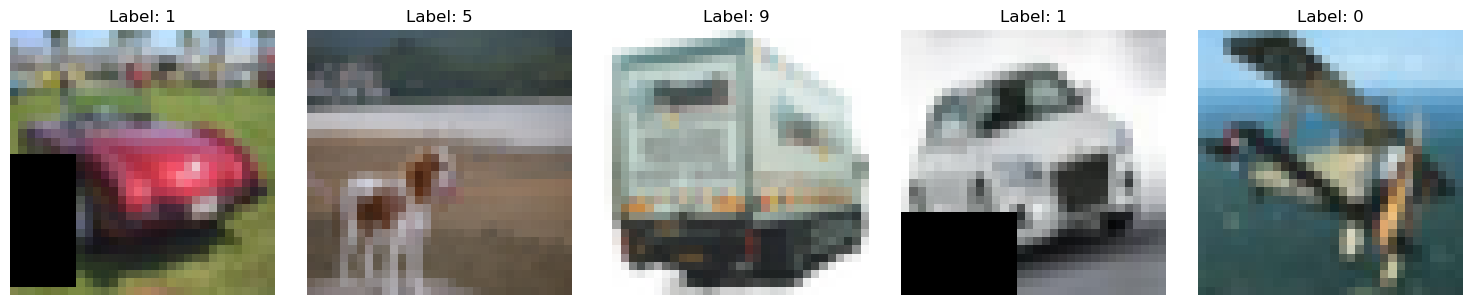

In [42]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random indices and plot the corresponding images
for i, idx in enumerate(random_indices):
    axs[i].imshow(x_train_cutoff[idx])
    axs[i].axis('off')  # Turn off the axis labels

    # Print the corresponding label
    label = np.argmax(y_train_cutoff[idx])
    axs[i].set_title(f"Label: {label}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()